In [1]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
import torch.nn as nn
from tqdm import tqdm
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
# Start by loading data, I save the labels as numbers instead of strings to make it compatible with the model.
images = []
labels = []
code2label = []
label_name = []
j = -1
directory = './dogs' 

for folder in os.scandir(directory): 
    if os.path.isdir(folder.path):
        j += 1
        label_name.append(folder.name)
        for file in os.scandir(folder.path):
            if not file.name.startswith('.'):
                images.append(plt.imread(file.path))
                labels.append(j)
                code2label.append(folder.name)

golden_retriever


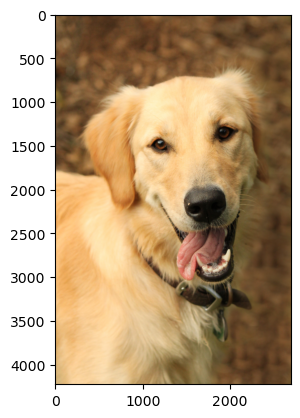

In [5]:
## Example of dataset
plt.imshow(images[0])
print(code2label[labels[0]])

In [6]:
## SEPARATE IN TRAINING AND VALIDATING
## I want to have every class present in training and validation and with the same amount of examples.

separator = int(np.floor(0.7*len(images))) #70 percent to training, 30 for validating
train_X = []
val_X = []
train_y = []
val_y = []
classes = 4
in_class = 20
separator = int(np.floor(0.7*in_class))

for i in range(classes):
    train_X = train_X + images[i*in_class:i*in_class+separator]
    train_y = train_y + labels[i*in_class:i*in_class+separator]
    val_X = val_X + images[i*in_class+separator:i*in_class+in_class]
    val_y = val_y + labels[i*in_class+separator:i*in_class+in_class]
    
train_X, train_y = shuffle(train_X, train_y)
val_X, val_y = shuffle(val_X, val_y)

In [7]:
## PRE-PROCESSING
## Add some transformations, as every image is of different sizes I keep one size for all and then 
## normalize values to 0 mean and 1 std. In hopes of solving overfitting product of a small dataset i include
## some image transformations in training.

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(512),                    
    transforms.CenterCrop(512),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(512),                    
    transforms.CenterCrop(512),
    transforms.RandomHorizontalFlip(),       
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [8]:
## DATA LOADERS
class dog_dataset(Dataset):
    def __init__(self,dogs,labels, transform):
        self.dogs = dogs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dogs)

    def __getitem__(self, idx):
        return self.transform(self.dogs[idx]), self.labels[idx]
    
batch = 4

train_dataset = dog_dataset(train_X, train_y, transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch,shuffle=True)
val_dataset = dog_dataset(val_X, val_y, transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch,shuffle=False)

In [19]:
## MODEL
## Simple model composed of cnns and linear. cnns is the obvious choice when working with images. 
## Add some drop out to help with overfitting

class DogClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 5, 3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 5, 5)
        self.fc1 = nn.Linear(5 * 126 * 126, 120)
        self.fc2 = nn.Linear(120, classes)
        self.re = nn.ReLU()
        self.drop = nn.Dropout(0.2)
        

    def forward(self,x):
        x = self.conv1(x)
        x = self.re(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.re(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.drop(x)
        x = self.fc1(x)
        x = self.re(x)
        x = self.drop(x)
        x = self.fc2(x)

        return x

In [20]:
## HYPER-PARAMETERS
learning_rate = 0.0001
num_epochs = 10

In [21]:
model = DogClassifier()

criterion = nn.CrossEntropyLoss() ## Common in multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate) ## Good optim function for these problems

In [22]:
## Function to control accuracy metric
def calculate_accuracy(model,dataloader):
    model.eval()
    num_correct = 0
    num_samples = 0
    lab = []
    pred = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            dog, label = data
            logits = model(dog)
    
            _, predictions = logits.max(1)
#             print(logits, predictions, label)
            num_correct += (predictions == label).sum() 
            num_samples += label.size(0)
#             pred.append(predictions.item())
#             lab.append(label.item())
    model.train()
    accuracy = float(num_correct) / float(num_samples) * 100
    print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")
#     return pred, lab

In [23]:
## TRAINING
## Looking at the training results, probably good to stop training around epoch 8, easily done with early stopping
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(train_dataloader)):

        dog, label = data
        logits = model(dog)
        loss = criterion(logits, label)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    
    calculate_accuracy(model, train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}]")


100%|███████████████████████████████████████████| 14/14 [00:04<00:00,  3.17it/s]


Got 19/56 with accuracy 33.93%
Epoch [1/10], Step [14/14]


100%|███████████████████████████████████████████| 14/14 [00:03<00:00,  4.27it/s]


Got 21/56 with accuracy 37.50%
Epoch [2/10], Step [14/14]


100%|███████████████████████████████████████████| 14/14 [00:03<00:00,  3.75it/s]


Got 28/56 with accuracy 50.00%
Epoch [3/10], Step [14/14]


100%|███████████████████████████████████████████| 14/14 [00:03<00:00,  4.06it/s]


Got 31/56 with accuracy 55.36%
Epoch [4/10], Step [14/14]


100%|███████████████████████████████████████████| 14/14 [00:03<00:00,  4.19it/s]


Got 30/56 with accuracy 53.57%
Epoch [5/10], Step [14/14]


100%|███████████████████████████████████████████| 14/14 [00:03<00:00,  4.64it/s]


Got 34/56 with accuracy 60.71%
Epoch [6/10], Step [14/14]


100%|███████████████████████████████████████████| 14/14 [00:02<00:00,  4.81it/s]


Got 33/56 with accuracy 58.93%
Epoch [7/10], Step [14/14]


100%|███████████████████████████████████████████| 14/14 [00:02<00:00,  4.76it/s]


Got 33/56 with accuracy 58.93%
Epoch [8/10], Step [14/14]


100%|███████████████████████████████████████████| 14/14 [00:02<00:00,  4.72it/s]


Got 34/56 with accuracy 60.71%
Epoch [9/10], Step [14/14]


100%|███████████████████████████████████████████| 14/14 [00:03<00:00,  4.55it/s]


Got 39/56 with accuracy 69.64%
Epoch [10/10], Step [14/14]


In [24]:
## Bad generalization, probably due to the very small amount of training data available, 
## even after trying many things to lower overfitting, accuracy was never good. Could perform grid search but im not
## sure it will improve much.
## Had to look for other alternatives. 
calculate_accuracy(model, val_dataloader)

Got 4/24 with accuracy 16.67%


In [26]:
## After some research and AI help found resnet, a pretrained network with a lot of images, 
## basically it has already done the training work for me. I can apply transfer learning to my model.

In [44]:
## Getting pretrained model and adding the final fully connected layer to match my classes
from torchvision import models

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 3 ## after seeing it reaches 100% in 3 i just selected 3 here

In [29]:
## instant improvement, reaches 100 percent in 2 epochs, maybe overfitting, we can add some other layers to help
# like drop out
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(train_dataloader)):

        dog, label = data
        logits = model(dog)
        loss = criterion(logits, label)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    
    calculate_accuracy(model, train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}]")

100%|███████████████████████████████████████████| 14/14 [00:12<00:00,  1.08it/s]


Got 54/56 with accuracy 96.43%
Epoch [1/3], Step [14/14]


100%|███████████████████████████████████████████| 14/14 [00:10<00:00,  1.28it/s]


Got 56/56 with accuracy 100.00%
Epoch [2/3], Step [14/14]


100%|███████████████████████████████████████████| 14/14 [00:11<00:00,  1.22it/s]


Got 56/56 with accuracy 100.00%
Epoch [3/3], Step [14/14]


In [30]:
## Accuracy much much better
calculate_accuracy(model, val_dataloader)

Got 21/24 with accuracy 87.50%


In [31]:
## Now i'm missing the "other" category. I'll say that if i classify something with less than 60% certainty 
## it is probably an "other". This threshold could be a hyperparameter wen doing a grid search. I also 
## apply softmax so that the threshold is easier to choose, softmax has a probability meaning while
## threshold has no meaning to us. 

In [34]:
import torch.nn.functional as F

def calculate_accuracy(model,dataloader, threshold):
    model.eval()
    num_correct = 0
    num_samples = 0
    lab = []
    pred = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            dog, label = data
            logits = model(dog)
            prob = F.softmax(logits, dim=1)
            max_log, predictions = prob.max(1)
            predictions = torch.where(max_log < threshold, classes, predictions)
#             print(prob, predictions, label)
            num_correct += (predictions == label).sum() 
            num_samples += label.size(0)
#             pred.append(predictions.item())
#             lab.append(label.item())
    model.train()
    accuracy = float(num_correct) / float(num_samples) * 100
    print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")
#     return pred, lab

In [35]:
## lets say if it is less than 50% certain it will be 'other'
calculate_accuracy(model, val_dataloader, 0.5)

Got 21/24 with accuracy 87.50%


In [36]:
## Adding other images to test (bunny, car, horse, st_bernard, daschund)
directory = './other' 
other = []
for file in os.scandir(directory):
    if not file.name.startswith('.'):
        print(file.name)
        other.append(plt.imread(file.path))

horse.jpg
daschund.jpg
bunny.jpg
car.jpeg
bernard.jpg


In [37]:
val_other_dataset = dog_dataset(other, np.ones(len(other))*4, transform)
val_other_dataloader = DataLoader(val_other_dataset, batch_size=1,shuffle=False)

In [38]:
calculate_accuracy(model,val_other_dataloader, 0.6)

Got 4/5 with accuracy 80.00%


In [47]:
## SAVE MODEL
torch.save(model.state_dict(), 'trained_classifier.pth')

In [48]:
## To caluclate accuracy with trained model use this with corresponding dataloader

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, classes)

model.load_state_dict(torch.load('trained_classifier.pth'))

calculate_accuracy(model,val_other_dataloader, 0.6)

Got 4/5 with accuracy 80.00%
